In [1]:
%load_ext autoreload
%autoreload 2

# Applying CRIPS-DM Methodology to a Business Problem

## Dataset 1 - Predicting Customer Churn in the Telecomunication Provider

## 3. Modeling

### 3.2. Logisitc Regression

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [4]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from joblib import dump

In [7]:
log_reg = LogisticRegression(random_state=8)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=8)

In [8]:
dump(log_reg, '../models/log_reg_1.joblib')

['../models/log_reg_1.joblib']

In [9]:
def logit(model):
    y_train_preds = model.predict(X_train)
    y_val_preds = model.predict(X_val)
    
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_val_probs = model.predict_proba(X_val)[:, 1]
    
    train_accuracy = accuracy_score(y_train, y_train_preds)
    train_precision = precision_score(y_train, y_train_preds)
    train_recall = recall_score(y_train, y_train_preds)
    train_f1 = f1_score(y_train, y_train_preds)
    train_roc_auc = roc_auc_score(y_train, y_train_probs)
    
    val_accuracy = accuracy_score(y_val, y_val_preds)
    val_precision = precision_score(y_val, y_val_preds)
    val_recall = recall_score(y_val, y_val_preds)
    val_f1 = f1_score(y_val, y_val_preds)
    val_roc_auc = roc_auc_score(y_val, y_val_probs)
    
    train_score = pd.DataFrame({
        'accuracy': train_accuracy,
        'precision': train_precision,
        'recall': train_recall,
        'f1-score': train_f1,
        'roc-auc': train_roc_auc}, index=['Training Set'])
    
    val_score = pd.DataFrame({
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1-score': val_f1,
        'roc-auc': val_roc_auc}, index=['Validation Set'])

    score = pd.concat([train_score, val_score])
    print(score)
    
    
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, normalize='true')
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, normalize='true')                                     
    
    plt.figure()
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    plt.plot(fpr_train, tpr_train, label='Train ROC-curve')
    plt.plot(fpr_val, tpr_val, label='Validate ROC-curve')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curve')
    plt.legend()
    
    plt.show()
    
    log_val = pd.DataFrame({'accuracy': val_accuracy,
                             'precision': val_precision,
                             'recall': val_recall,
                             'f1-score': val_f1,
                             'roc-auc': val_roc_auc}, index=['Logistic Regression'])
    
    return(log_val)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.871324       0.66  0.172775  0.273859  0.755146
Validation Set  0.861765       0.55  0.114583  0.189655  0.710028


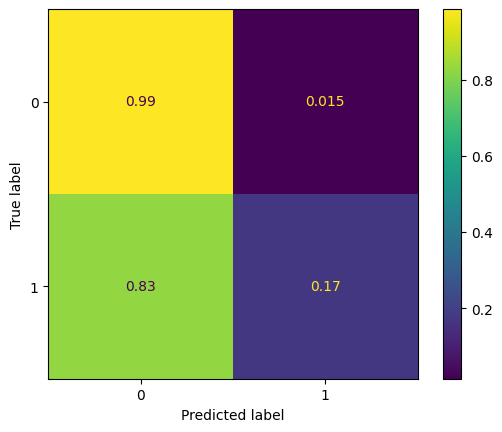

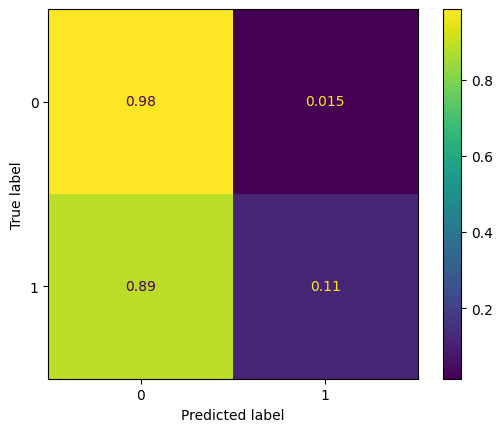

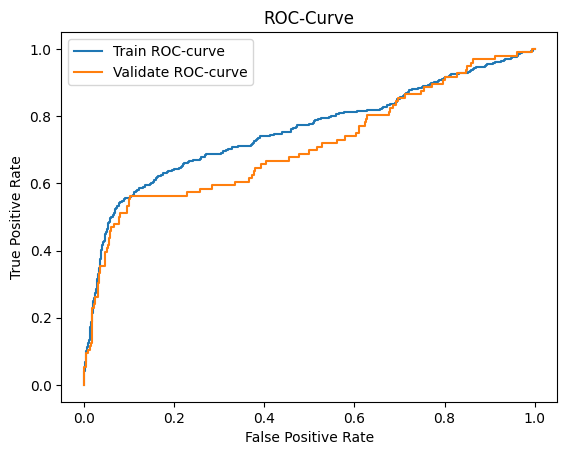

,accuracy,precision,recall,f1-score,roc-auc
Logistic Regression,0.861765,0.55,0.114583,0.189655,0.710028


In [10]:
logit(log_reg)

The model perform really well on the training set, however it doesn't perform as effective to the validation set. There were a drop in all performance metrics suggesting that there might be an overfitting to the training data. We'll try to do the hyperparameter tuning to see if we can address this issues.

### Reduce Overfitting with C

default = 1

In [11]:
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [12]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in c:
    log = LogisticRegression(random_state=8, max_iter=1000, C=i).fit(X_train, y_train)
    y_train_preds = log.predict(X_train)
    y_val_preds = log.predict(X_val)
    
    y_train_probs = log.predict_proba(X_train)[:, 1]
    y_val_probs = log.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_c = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=c)

tune_c

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0.001,0.859559,0.858824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.691454,0.608876
0.010,0.862868,0.861765,1.000000,1.000000,0.023560,0.020833,0.046036,0.040816,0.721312,0.658390
0.100,0.869853,0.866176,0.712121,0.647059,0.123037,0.114583,0.209821,0.194690,0.750937,0.706443
1.000,0.871324,0.861765,0.660000,0.550000,0.172775,0.114583,0.273859,0.189655,0.755146,0.710028
10.000,0.870588,0.863235,0.647059,0.571429,0.172775,0.125000,0.272727,0.205128,0.755556,0.710545
100.000,0.870588,0.863235,0.644231,0.571429,0.175393,0.125000,0.275720,0.205128,0.755614,0.710634
1000.000,0.870588,0.863235,0.644231,0.571429,0.175393,0.125000,0.275720,0.205128,0.755613,0.710563


In [13]:
def plot_performance(parameter, xlabel):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 5))
    
    ax1.plot(parameter, train_accuracy, label='train accuracy')
    ax1.plot(parameter, val_accuracy, label='val accuracy')
    ax1.legend()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy Score')
    
    ax2.plot(parameter, train_precision, label='train precision')
    ax2.plot(parameter, val_precision, label='val precision')
    ax2.legend()
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('precision')
    ax2.set_title('Precision Score')
    
    ax3.plot(parameter, train_recall, label='train recall')
    ax3.plot(parameter, val_recall, label='val recall')
    ax3.legend()
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel('recall')
    ax3.set_title('Recall Score')
    
    ax4.plot(parameter, train_f1, label='train f1')
    ax4.plot(parameter, val_f1, label='val f1')
    ax4.legend()
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel('f1')
    ax4.set_title('F1-Score')
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    ax5.plot(fpr_train, tpr_train, label='train roc-auc')
    ax5.plot(fpr_val, tpr_val, label='val roc-auc')
    ax5.legend()
    ax5.set_xlabel('false positive rate')
    ax5.set_ylabel('true positive rate')
    ax5.set_title('ROC-AUC Score')
    
    plt.subplots_adjust(wspace=0.4)
    plt.show()    

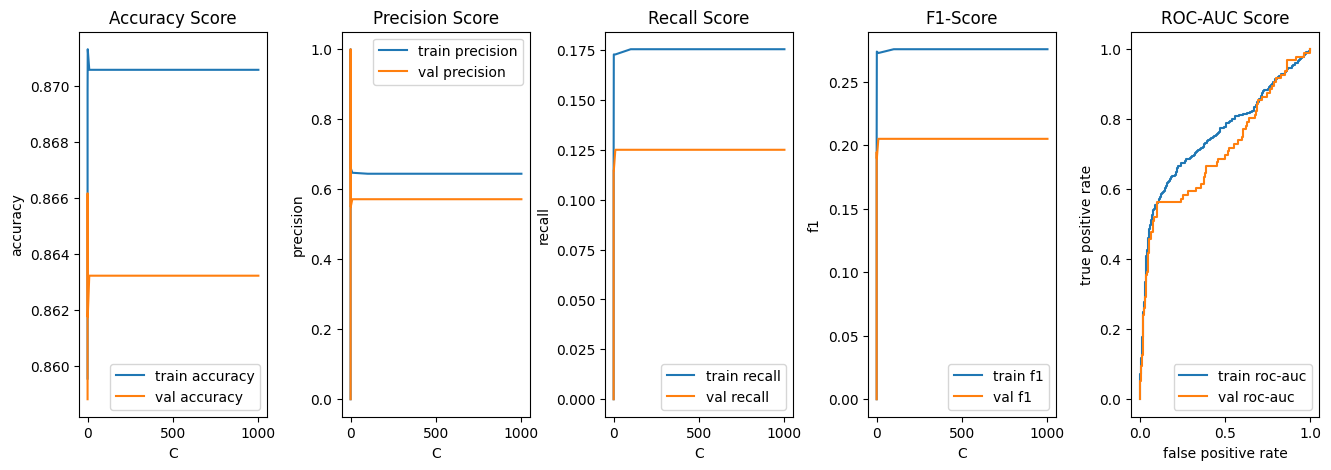

In [14]:
plot_performance(c, 'C')

### Reduce Overfitting with Solver

default = lgfgs

In [16]:
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

In [17]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in solver:
    log = LogisticRegression(random_state=8, max_iter=1000, C=1, solver=i).fit(X_train, y_train)
    y_train_preds = log.predict(X_train)
    y_val_preds = log.predict(X_val)
    
    y_train_probs = log.predict_proba(X_train)[:, 1]
    y_val_probs = log.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_solver = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=solver)

tune_solver

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
lbfgs,0.892002,0.875,0.960321,0.612245,0.817793,0.3125,0.883345,0.413793,0.934789,0.715308
liblinear,0.890932,0.875,0.959759,0.612245,0.816082,0.3125,0.882108,0.413793,0.934716,0.714951
newton-cg,0.892002,0.875,0.960321,0.612245,0.817793,0.3125,0.883345,0.413793,0.934787,0.715343
newton-cholesky,0.892002,0.875,0.960321,0.612245,0.817793,0.3125,0.883345,0.413793,0.934786,0.715343
sag,0.892002,0.875,0.960321,0.612245,0.817793,0.3125,0.883345,0.413793,0.934786,0.715308
saga,0.892002,0.875,0.960321,0.612245,0.817793,0.3125,0.883345,0.413793,0.934786,0.715325


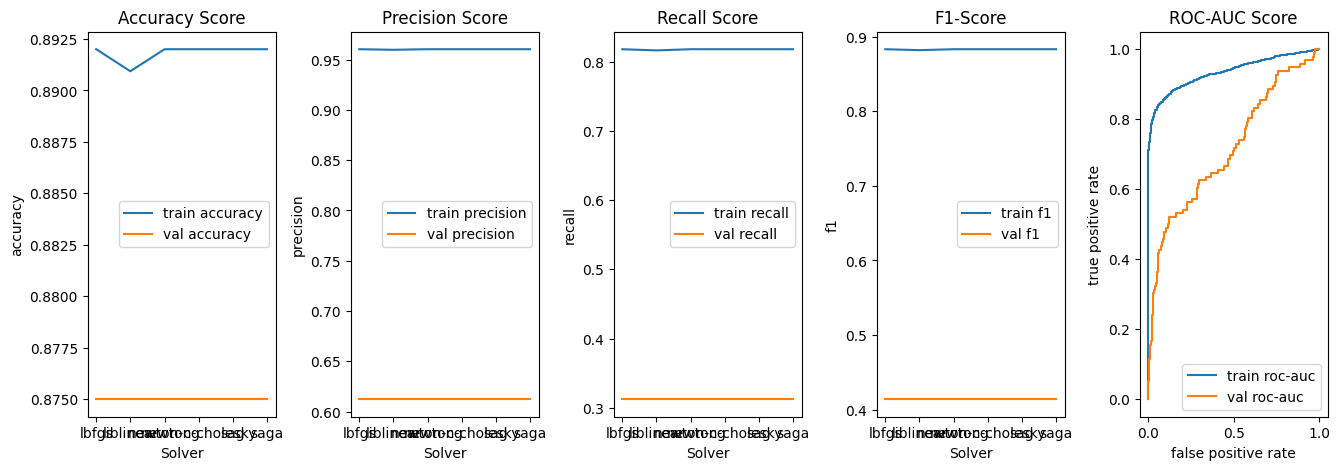

In [18]:
plot_performance(solver, 'Solver')

### Reduce Overfitting with Penalty

Penalty supprot by solver=lbfgs

default = l2

In [19]:
penalty = ['l2', 'none']

In [20]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in penalty:
    log = LogisticRegression(random_state=8, max_iter=1000, C=1, solver='lbfgs', penalty=i).fit(X_train, y_train)
    y_train_preds = log.predict(X_train)
    y_val_preds = log.predict(X_val)
    
    y_train_probs = log.predict_proba(X_train)[:, 1]
    y_val_probs = log.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_penalty = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=penalty)

tune_penalty

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
l2,0.892002,0.875000,0.960321,0.612245,0.817793,0.3125,0.883345,0.413793,0.934789,0.715308
none,0.890505,0.870588,0.958794,0.576923,0.816082,0.3125,0.881701,0.405405,0.935312,0.711776


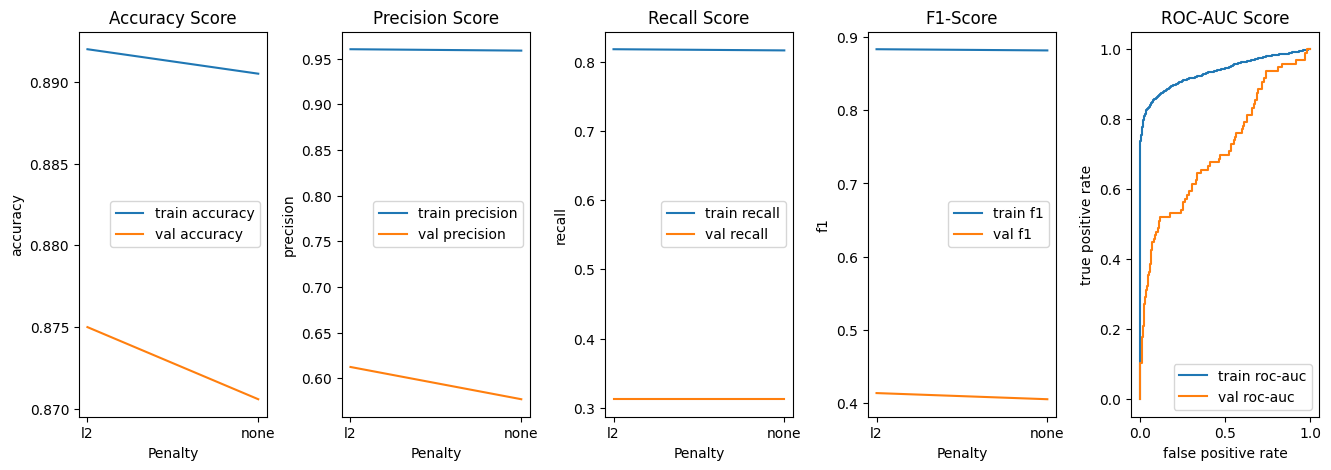

In [21]:
plot_performance(penalty, 'Penalty')

### Reduce Overfitting with Multi-Class Handling

default = auto

In [22]:
multi_class = ['auto', 'ovr', 'multinomial']

In [23]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in multi_class:
    log = LogisticRegression(random_state=8, max_iter=1000, C=1, solver='lbfgs', penalty='l2', multi_class=i).fit(X_train, y_train)
    y_train_preds = log.predict(X_train)
    y_val_preds = log.predict(X_val)
    
    y_train_probs = log.predict_proba(X_train)[:, 1]
    y_val_probs = log.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_multi_class = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=multi_class)

tune_multi_class

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
auto,0.892002,0.875,0.960321,0.612245,0.817793,0.3125,0.883345,0.413793,0.934789,0.715308
ovr,0.892002,0.875,0.960321,0.612245,0.817793,0.3125,0.883345,0.413793,0.934789,0.715308
multinomial,0.891360,0.875,0.959337,0.612245,0.817365,0.3125,0.882679,0.413793,0.934815,0.714416


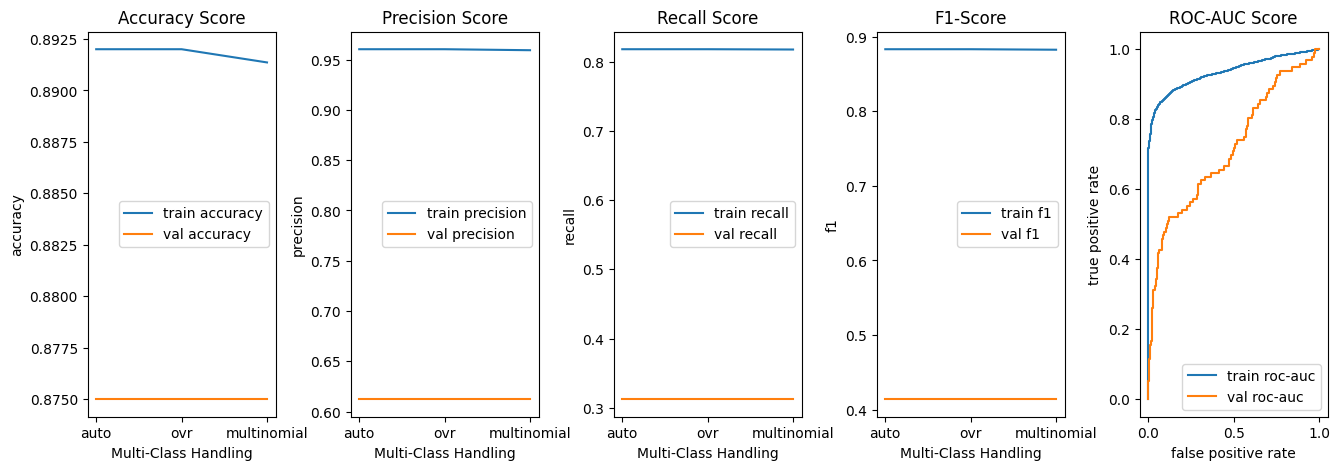

In [24]:
plot_performance(multi_class, 'Multi-Class Handling')

### Model After Hyperparameter Tuning

In [25]:
log_reg_tune = LogisticRegression(random_state=8, max_iter=1000, C=1, solver='lbfgs', penalty='l2', multi_class='auto') 
log_reg_tune.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=8)

In [26]:
dump(log_reg_tune, '../models/log_reg_tune.joblib')

['../models/log_reg_tune.joblib']

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.892002   0.960321  0.817793  0.883345  0.934789
Validation Set  0.875000   0.612245  0.312500  0.413793  0.715308


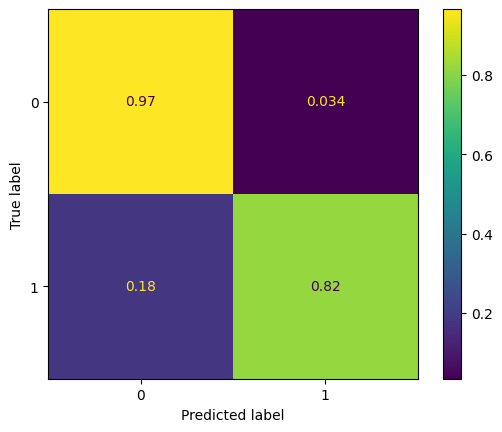

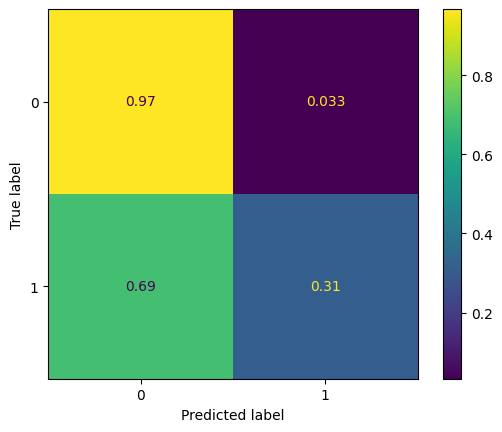

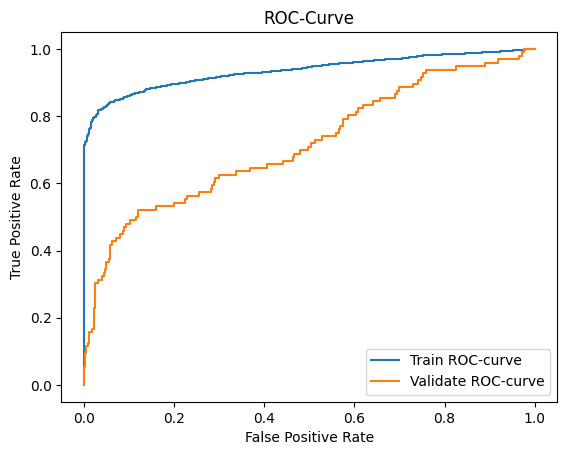

In [27]:
logistic = logit(log_reg_tune)

**True Positive**: Correctly predicted "churn"

**True Negative**: Correctly predicted "not churn"

**False Positive**: Predicted "churn", but actually "not churn"

**False Negative**: Predicted "not churn", but actually "churn"



- The low True Positive (31%) in the validation set mean that the model is missing out on correctly identifying customers who are at risk of churning and could lead to miss opportunity for retention.

- The high False Negative (69%) in the validation set suggest that the model might not be able to capture the actual churn customers and predicted as not churn.

In [2]:
logistic.to_csv('../data/processed/model/1_logistic.csv', index=False)

NameError: name 'logistic' is not defined